In [1]:
import utils
from utils import *
%matplotlib inline
from sys import getsizeof

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5103)


In [2]:
target_size = (100,100)#(256, 256)

In [3]:
K.set_image_data_format('channels_first')
K.image_data_format()

'channels_first'

### Load Data

In [4]:
x_train = []
y_train = []

df_train = pd.read_csv('data/train_v2.csv')
df_test = pd.read_csv('data/sample_submission_v2.csv')

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

labels = ['blow_down',
 'bare_ground',
 'conventional_mine',
 'blooming',
 'cultivation',
 'artisinal_mine',
 'haze',
 'primary',
 'slash_burn',
 'habitation',
 'clear',
 'road',
 'selective_logging',
 'partly_cloudy',
 'agriculture',
 'water',
 'cloudy']

label_map = {'agriculture': 14,
 'artisinal_mine': 5,
 'bare_ground': 1,
 'blooming': 3,
 'blow_down': 0,
 'clear': 10,
 'cloudy': 16,
 'conventional_mine': 2,
 'cultivation': 4,
 'habitation': 9,
 'haze': 6,
 'partly_cloudy': 13,
 'primary': 7,
 'road': 11,
 'selective_logging': 12,
 'slash_burn': 8,
 'water': 15}

In [5]:
train_gen = image.ImageDataGenerator( 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

### Load JPEG files

In [6]:
# from PIL import Image as pil_image
# img = pil_image.open('data/train-jpg/{}.jpg'.format(df_train.image_name[100])).convert('RGB') 
# img

In [7]:

# for f, tags in tqdm(df_train.values, miniters=1000):
#     img = cv2.imread('data/train-jpg/{}.jpg'.format(f))a
#     targets = np.zeros(17)
    
#     for t in tags.split(' '):
#         targets[label_map[t]] = 1 
        
#     img =  cv2.cvtColor(cv2.resize(img, target_size), cv2.COLOR_BGR2RGB)   
#     x_train.append(img)
#     y_train.append(targets)


In [8]:
# ## making num items good for divisions
# x_train.append(x_train[0])
# y_train.append(y_train[0])

In [9]:
# x_test = []

# for f, tags in tqdm(df_test.values, miniters=1000):
#     img = cv2.imread('data/test-jpg/{}.jpg'.format(f))
#     img =  cv2.cvtColor(cv2.resize(img, target_size), cv2.COLOR_BGR2RGB)   

#     x_test.append(cv2.resize(img, target_size))


In [10]:
# y_train = np.array(y_train, np.uint8)
# x_train = np.array(x_train, np.float32) #/ 255.
# x_test  = np.array(x_test, np.float32) #/ 255.

# #Transpose the data if using Theano

# x_train = x_train.transpose((0, 3, 1, 2))
# x_test = x_test.transpose((0, 3, 1, 2))





In [11]:
# save_array("data/cache/xtrain_100x100.dat",x_train)
# save_array("data/cache/xtest_100x100.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

# # save_array("data/cache/xtrain_50x50.dat",x_train)
# save_array("data/cache/xtest_50x50.dat",x_test)
# save_array("data/cache/ytrain.dat",y_train)

In [8]:
x_train = load_array("data/cache/xtrain_{}x{}.dat".format(target_size[0],target_size[1]))



In [13]:
# x_test = load_array("data/cache/xtest_100x100.dat")


In [14]:
# x_train[:,0,:,:].mean(), x_train[:,1,:,:].mean(),x_train[:,2,:,:].mean()

In [15]:
print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)


(40480, 3, 100, 100)


#### creating rare labels

In [14]:
y_train = load_array("data/cache/ytrain.dat")


In [15]:
# rare_labels = set(labels) - set(['primary', 'agriculture', 'water', 'cultivation', 'habitation','road']) - \
# set(['clear','cloudy','haze','partly_cloudy'])

In [16]:
rare_labels = ['slash_burn']

In [17]:
rare_label_indices = []
for i in rare_labels:
    rare_label_indices.append(label_map[i])

In [18]:
rare_label_indices

[8]

In [19]:
y_train = y_train[:,rare_label_indices]


In [20]:
from sklearn.utils import class_weight
new_class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train.ravel()), y_train.ravel())

In [21]:
new_class_weights

array([  0.5026,  96.8421])

In [22]:
y_train.sum()

209

In [18]:
# y_train = np.hstack(((y_train.ravel() ==0 ).reshape(-1,1),y_train))

In [29]:
y_train.shape

(40480, 1)

#### Loading Image features 

In [151]:
oleg_train = load_array("data/cache/oleg_train")
oleg_train = oleg_train[:,2:]
oleg_train= np.append(oleg_train,oleg_train[0].reshape(1,-1),axis=0)

In [99]:
mahotas_features = load_array("data/cache/mahotas_14_jpg_train.dat/")
mahotas_features= np.append(mahotas_features,mahotas_features[0].reshape(1,-1),axis=0)

In [134]:
extra_features_dev  = np.hstack((oleg_train, mahotas_features))

### Making a sample

In [49]:
np.random.seed(2089)

perm = np.random.permutation(len(x_train))
idx_sample = perm[:int(len(x_train)*0.5)]

x_sample = x_train[idx_sample]
y_sample = y_train[idx_sample]

x_sample.shape, y_sample.shape

((20240, 3, 100, 100), (20240, 1))

In [50]:
# oleg_sample = oleg_train[idx_sample]

In [51]:
# mahotas_sample = mahotas_features[idx_sample]

In [52]:
# extra_features_dev  = extra_features_dev[idx_sample]

### Model Training 


In [23]:
nf=64; p=0.6

def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape= (256, 25, 25)), #conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,(3,3), activation='relu', padding='valid'),
        Dropout(p/2),

##         MaxPooling2D(),

        BatchNormalization(axis=1),

##         MaxPooling2D(),
        Convolution2D(nf,(3,3), activation='relu', padding='valid'),
        Dropout(p/2),

        BatchNormalization(axis=1),
##         MaxPooling2D(),
        Convolution2D(nf,(3,3), activation='relu', padding='valid'),
        Dropout(p/2),
        
        BatchNormalization(axis=1),


        
### temp experiment with dense on top  
#         Dropout(0.4),   
        Flatten(),

        Dense(512,activation='relu'),
        BatchNormalization(),
        Dropout(p),  
        
#         Dense(512,activation='relu'),
#         BatchNormalization(),
#         Dropout(0.6),  
        
        Dense(512,activation='relu'),
        BatchNormalization(),
        Dropout(p),  
        
        Dense(1,activation='sigmoid')
        
### temp experiment with dense on top         
#         BatchNormalization(axis=1),
        
#         MaxPooling2D(),
#         Convolution2D(4,(3,3), padding='same'),
#         Dropout(p),
#         GlobalAveragePooling2D(),
# #         GlobalMaxPooling2D(),
#         Activation('softmax')
    ]



In [24]:
def create_base_vgg(extend_top=False,size=(100,100)):
    model = Vgg16BN(size).model

    
    for i in range (15): #excluding the six 512 blocks at the top, was 15
        model.pop()

    for l in model.layers:
        l.trainable = False 
    
    
    if extend_top:
        for l in get_lrg_layers(): 
            model.add(l)
            
            
    return model


In [25]:
from keras.layers import concatenate 
def create_fcn_plus_features_model(feature_length):
    
    feature_input = Input(shape=(feature_length,))
    
    
    vgg_input =  Input(shape=(256, 25, 25))
    fcn_model = BatchNormalization(axis=1, input_shape=(256, 25, 25))(vgg_input)
    fcn_model = Convolution2D(nf,(3,3), activation='relu', padding='valid')(fcn_model)
    fcn_model = Dropout(p/2)(fcn_model)
    
    fcn_model = BatchNormalization(axis=1)(fcn_model)
    fcn_model = Convolution2D(nf,(3,3), activation='relu', padding='valid')(fcn_model)
    fcn_model = Dropout(p/2)(fcn_model)
 
    fcn_model = BatchNormalization(axis=1)(fcn_model)
    fcn_model = Convolution2D(nf,(3,3), activation='relu', padding='valid')(fcn_model)
    fcn_model = Dropout(p/2)(fcn_model)
    
    fcn_model = Flatten()(fcn_model)

    
    top_dense = concatenate([fcn_model,feature_input])
    top_dense =  BatchNormalization()(top_dense)
    
    ## Add dense layers on top 
    top_dense = Dense(512,activation='relu')(top_dense)
    top_dense = BatchNormalization()(top_dense)
    top_dense = Dropout(p)(top_dense)
    
    top_dense = Dense(512,activation='relu')(top_dense)
    top_dense = BatchNormalization()(top_dense)
    top_dense = Dropout(p)(top_dense)    
    
    top_dense = Dense(4,activation='softmax')(top_dense)
    
    
    model  = Model (inputs = [vgg_input,feature_input], outputs=top_dense)
    
    return model 

In [26]:
vgg_common = create_base_vgg()
vgg_common.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])


In [27]:
#conv_layers,_ = split_at(vgg_common, Convolution2D)

fully_conv_model =  Sequential(get_lrg_layers())


#### End-to-end Model (no precomputations)

In [69]:
#if training end-to-end; e.g. because can't cache precomputations due to memory constraints 
# end_to_end = create_base_vgg(True)
# end_to_end.layers.extend(fully_conv_model.layers)

In [119]:
# end_to_end.summary()

#### FCN + Summary features

In [163]:
# fcn_plus_feats_model = create_fcn_plus_features_model(oleg_sample.shape[1]) #+ oleg 0.90678 made results worse, may have to do with thresholds

# fcn_plus_feats_model = create_fcn_plus_features_model(mahotas_features.shape[1]) 

### Quick training and prediction (on SAMPLE data)

In [59]:
VALIDATION_SPLIT = 0.1
np.random.seed(2089)

perm = np.random.permutation(len(x_sample))
idx_train = perm[:int(len(x_sample)*(1-VALIDATION_SPLIT))]
idx_val = perm[int(len(x_sample)*(1-VALIDATION_SPLIT)):]

In [60]:
X_train = x_sample[idx_train]
Y_train = y_sample[idx_train]
X_valid = x_sample[idx_val]
Y_valid = y_sample[idx_val]


# oleg_sample_train = oleg_sample[idx_train]
# oleg_sample_valid = oleg_sample[idx_val]

# mahotas_sample_train = mahotas_sample[idx_train]
# mahotas_sample_valid= mahotas_sample[idx_val]

# extra_features_train = extra_features_dev[idx_train]
# extra_features_valid= extra_features_dev[idx_val]

In [33]:
X_train.shape


(18216, 3, 100, 100)

In [34]:
# conv_trn_feat = vgg_common.predict(X_train, batch_size=32, verbose=1)
# save_array("data/cache/conv_trn_feat_100x100.dat",conv_trn_feat)

In [35]:
conv_trn_feat = load_array("data/cache/conv_trn_feat_100x100.dat")

In [36]:
conv_valid_feat = vgg_common.predict(X_valid, batch_size=32, verbose=1)


2016/2024 [============================>.] - ETA: 0s

#### With Augmentation

In [129]:
conv_trn_featx2 = np.memmap("data/cache/vgg_features_train_100x100_part2of5.planet", dtype='float32', mode='r', 
            shape=(8096*2,256, 25, 25))



In [113]:
batch_size = 32

In [118]:
train_gen = image.ImageDataGenerator( 
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)


#Make sure to set shuffle to FALSE!! for pre-computations
train_batch = train_gen.flow(X_train,Y_train,batch_size=batch_size,shuffle=False)

#verify augmentation results:
#,save_to_dir="data/tmp/aug_v1/",save_prefix="v1")

In [121]:
# conv_trn_featx2   = vgg_common.predict_generator(train_batch, steps=math.ceil(len(X_train)/float(batch_size)),verbose=1) 

In [ ]:
conv_trn_featx2.shape[0] -X_train.shape[0]*2

In [ ]:
save_array("data/cache/conv_trn_feat_augx2_jpg100.dat",conv_trn_featx2)

In [ ]:
#adding non-augmented photos too
conv_trn_feat = np.vstack((conv_trn_featx2,)) 

In [ ]:
Y_train = np.concatenate([Y_train]*3)

--- 


In [28]:

kfold_weights_path = os.path.join('weights/', 'vgg_sample_v1_exp.h5')


#              ReduceLROnPlateau(monitor='val_loss',  patience=3, verbose=1, factor=0.1, min_lr=1e-7)
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)
            ]



In [30]:
#binary_crossentropy
fully_conv_model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# end_to_end.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

# fcn_plus_feats_model.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])

Training

In [ ]:
kf = KFold( n_splits=5, shuffle=True, random_state=2020)

for train_index, valid_index in kf.split(y_train):
        # start_time_model_fitting = time.time()
 
    X_train = x_train[train_index]
    X_valid = x_train[valid_index]

    Y_train = y_train[train_index]
    Y_valid = y_train[valid_index]
    
#     conv_trn_feat = vgg_common.predict(X_train, batch_size=32, verbose=1)
#     save_array("data/cache/conv_trn_feat_tmp_5fold.dat",conv_trn_feat)
    conv_trn_feat = load_array("data/cache/conv_trn_feat_tmp_5fold.dat")

#     conv_valid_feat = vgg_common.predict(X_valid, batch_size=32, verbose=1)
# save_array("data/cache/conv_valid_feat_tmp_5fold.dat",conv_valid_feat)
    conv_valid_feat = load_array("data/cache/conv_valid_feat_tmp_5fold.dat")
    
    
    
    
    history = fully_conv_model.fit(x = conv_trn_feat, y= Y_train, validation_data=(conv_valid_feat, Y_valid),
      batch_size=64, epochs=50,callbacks=callbacks, class_weight={0:new_class_weights[0],1:new_class_weights[1]},
      shuffle=True)
    
    
    break

Train on 32384 samples, validate on 8096 samples
Epoch 1/50
32320/32384 [============================>.] - ETA: 0s - loss: 0.9883 - acc: 0.5581

In [81]:
## FCN

# history = fully_conv_model.fit(x = conv_trn_feat, y= Y_train, validation_data=(conv_valid_feat, Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks, class_weight={0:new_class_weights[0],1:new_class_weights[1]},
#   shuffle=True)


## FCN+features 

# history = fcn_plus_feats_model.fit(x = [conv_trn_feat,mahotas_sample_train], y= Y_train, 
#                                    validation_data=([conv_valid_feat,mahotas_sample_valid], Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks,
#   shuffle=True)


## end-to-end
#     history = end_to_end.fit_generator(train_batch, steps_per_epoch=len(X_train)/batch_size,
#                                        validation_data=(X_valid, Y_valid),
#                                        epochs=1,callbacks=callbacks)


# history = model.fit_generator(train_gen.flow(conv_trn_feat, Y_train), validation_data=(conv_valid_feat, Y_valid),
#   batch_size=64, epochs=50,callbacks=callbacks,
#   shuffle=True)




#### verifying results

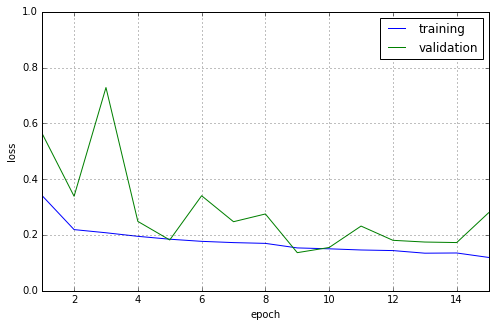

In [43]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("loss")
ax.set_ylim([0.0,1.0]);

In [44]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print 'Minimum loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss)

max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print 'Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc)

Minimum loss at epoch 9 = 0.1367
Maximum accuracy at epoch 10 = 0.9380


In [45]:
model  = fully_conv_model

if os.path.isfile(kfold_weights_path):
    print "loading best weights from '{}'".format(kfold_weights_path)
    fully_conv_model.load_weights(kfold_weights_path)
    
    

loading best weights from 'weights/vgg_sample_v1_exp.h5'


In [46]:
preds_val = fully_conv_model.predict(conv_valid_feat)


In [47]:
class_0_preds = 1 - preds_val.ravel()

In [48]:
preds_val = np.hstack((class_0_preds.reshape(-1,1), preds_val.reshape(-1,1)))

In [49]:
# print('F2 Score:', f2_score(Y_valid.ravel(), preds_val.ravel()>0.08))

In [50]:
target_val = np.hstack(((Y_valid.ravel()==0).astype(np.uint8).reshape(-1,1),Y_valid.reshape(-1,1)))

In [51]:

def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    num_classes = 2
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(num_classes):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*num_classes
    for i in range(num_classes):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            threshold = float(i2) / resolution
            x[i] = threshold
            score = mf(x)
            if score > best_score:
                best_i2 = threshold
                best_score = score

        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x

In [52]:
thres = optimise_f2_thresholds(target_val, preds_val)
np.mean(thres)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


(0, 0.65, 0.96405632411067199)
(1, 0.06, 0.97838438735177868)


0.35499999999999998

In [53]:
rare_labels

['primary']

In [54]:
rare_class_prediction = preds_val[:,1] > thres[1]
others_prediction = rare_class_prediction == 0 


In [55]:
preds_val = np.hstack((others_prediction.reshape(-1,1),rare_class_prediction.reshape(-1,1)))

In [56]:
target_val  = target_val.astype(np.uint8)

In [57]:
from sklearn import metrics


In [59]:
report = metrics.classification_report(target_val, preds_val.astype(np.uint8), target_names=["others", rare_labels[0]])
print(report)    

             precision    recall  f1-score   support

     others       0.91      0.52      0.66       547
    primary       0.97      1.00      0.98      7549

avg / total       0.96      0.96      0.96      8096



In [94]:

report = metrics.classification_report(Y_valid, preds_val.astype(np.uint8), target_names=["others", "artisinal mining"])
print(report)    

                  precision    recall  f1-score   support

          others       1.00      1.00      1.00      2003
artisinal mining       0.64      0.86      0.73        21

     avg / total       0.99      0.99      0.99      2024



In [126]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_true=Y_valid[:,0],y_pred=preds[:,2])

array([[1982,   28],
       [  14,    0]])

### Making Prediction

In [46]:
#clear memory
del x_train, X_train, X_valid, conv_trn_feat, conv_valid_feat
x_test = load_array("data/cache/xtest_100x100.dat")


In [45]:
oleg_test = load_array("data/cache/oleg_test")
oleg_test = oleg_test[:,2:]

In [47]:
mahotas_test = load_array("data/cache/mahotas_14_jpg_test.dat")

In [50]:
# preds = make_staged_predictions(x_test,num_parts=5,do_augmentation=False)
preds = make_staged_predictions_with_features(model=model,data=x_test, features=mahotas_test,num_parts=5,do_augmentation=False)

data has shape:  (61191, 3, 100, 100)
breaking data into chunks of  12238

predicting part  1

predicting part  2

predicting part  3

predicting part  4

predicting part  5

predicting part  6


In [51]:
save_array("data/cache/preds_vgg_and_mahotas_samples.dat",preds)

In [52]:
preds.shape, x_test.shape

((61191, 17), (61191, 3, 100, 100))

In [49]:

def make_staged_predictions_with_features(model, data,features,num_parts, do_augmentation=False):
    partial_preds = []
    nb_aug = 1

    vgg_common = create_base_vgg()
    vgg_common.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

    chunck_size = len(data)/num_parts

    print "data has shape: ", data.shape
    print "breaking data into chunks of ", chunck_size
    

    # do prediction on normal photos anyways
    for i in range(1,num_parts+2):
        print ""
        print "predicting part ",i
        
        start_index = (i-1)*chunck_size
        end_index = min(len(data),i*chunck_size)
        num_items = end_index-start_index
        
        
        
        vgg_test_feat = vgg_common.predict(data[start_index:end_index], batch_size=32, verbose=0)
        partial_preds.append(model.predict([vgg_test_feat,features[start_index:end_index]], batch_size=32, verbose=0))
        del vgg_test_feat   

    
    normal_image_preds = np.vstack(partial_preds)
    
    
    if not do_augmentation:
        return   normal_image_preds  

    
    
    else: ## test augmentation 
        augmented_predictions = normal_image_preds 
        for n in range(nb_aug):
            print ""
            print "augmentation round {} of {}".format(n+1,nb_aug) 
            partial_preds = []

            for i in range(1,num_parts+2):
                print ""
                print "predicting part {} of {}".format(i,num_parts)      
                
                start_index = (i-1)*chunck_size
                end_index = min(len(data),i*chunck_size)
                num_items = end_index-start_index
                
                
                test_batch = train_gen.flow(data[start_index:end_index],batch_size=16,shuffle=False)
                
                vgg_test_feat = vgg_common.predict_generator(test_batch, steps=math.ceil(num_items/16.0) ,verbose=1) 
                
#                 print ""
#                 print ("items needed vs. items generated: ",num_items,len(vgg_test_feat) )
                
                vgg_test_feat = vgg_test_feat[:num_items] #to make sure we only take as much as we need for this batch 
                
                partial_preds.append(model.predict(vgg_test_feat, batch_size=32, verbose=1))
                
                
            augmented_predictions += np.vstack(partial_preds)
            
        augmented_predictions /= (nb_aug+1) #including normal photo predictions
        return augmented_predictions

    
    


### K-fold cross validation

In [18]:

nfolds = 2

current_fold = 0
sum_score = 0

yfull_test = []
# yfull_train =[]
thresholds = []
oof_preds = np.zeros((x_train.shape[0],17))


val_errors = []
val_accuracies = []

       
kf = KFold( n_splits=nfolds, shuffle=True, random_state=2020)

for train_index, valid_index in kf.split(x_sample,y_sample):
        start_time_model_fitting = time.time()
        
        X_train = x_sample[train_index]
        Y_train = y_sample[train_index]
        X_valid = x_sample[valid_index]
        Y_valid = y_sample[valid_index]
        

        current_fold += 1
        print('Start KFold number {} from {}'.format(current_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        
        kfold_weights_path = os.path.join('weights/', 'vgg1_weights_kfold_' + str(current_fold) + '.h5')
        callbacks = [EarlyStopping(monitor='val_loss', patience=3),
                     ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)]
 




        ##################   TRAINING
        print ("Creating VGG features")
        print ("conv_trn_feat")

        # standard photos
        conv_trn_feat = vgg_common.predict(X_train, batch_size=32, verbose=0)
        print ""
        print ("conv_trn_feat, augmented")
        
        # augmented photos (1x due to memory constraints)
        train_batch = train_gen.flow(X_train,Y_train,batch_size=16,shuffle=False,seed=current_fold)
        conv_trn_featx1   = vgg_common.predict_generator(train_batch, steps=math.ceil(len(X_train)/16.0) ,verbose=0) 
        
        conv_trn_feat = np.vstack((conv_trn_feat,conv_trn_featx1))
        Y_train = np.concatenate([Y_train]*2) #duplicate targets too
        
        del conv_trn_featx1
        print ""
        print ("conv_valid_feat")
        
        conv_valid_feat = vgg_common.predict(X_valid, batch_size=32, verbose=0)
#         conv_test_feat = vgg640.predict(x_test, batch_size=32, verbose=1)
        print ""
        print ("Training round {}".format(current_fold))
 
        model =  Sequential(get_lrg_layers())
        model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

        
        
        ######## ACTION
        history = model.fit(x = conv_trn_feat, y= Y_train, validation_data=(conv_valid_feat, Y_valid),
          batch_size=32, epochs=1,callbacks=callbacks,
          shuffle=True,verbose=1)

        
        
        ######################## VALIDATION 
        
        if os.path.isfile(kfold_weights_path):
            print ""
            print ("loading best weights from ",kfold_weights_path)
            model.load_weights(kfold_weights_path)
            
        
        ## verifying local validation results
        p_valid = model.predict(conv_valid_feat, batch_size = 64, verbose=1)
        print("local score with threshold 0.08: ",f2_score(Y_valid, np.array(p_valid) > 0.08))
        print("Optimizing prediction threshold")
        local_best_thresholds = optimise_f2_thresholds(Y_valid, p_valid)
#         print(local_best_thresholds)
        thresholds.append(local_best_thresholds)

        
        ## oof preds
        oof_preds[valid_index] = p_valid
        del conv_trn_feat,conv_valid_feat 
        
        
        
        
        min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
        print 'Minimum loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss)

        max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
        print 'Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc)
        
        val_errors.append(min_val_loss)
        val_accuracies.append(max_val_acc)
        

        ############################# TEST PREDICTION
        del X_train, Y_train, X_valid, Y_valid
        x_test = load_array("data/cache/xtest_100x100.dat")

        ## doing test predictions 
        print("Predicting test files")
        
        p_test = make_staged_predictions(x_test,num_parts=5,do_augmentation=True)        
        yfull_test.append(p_test)

        del model # make sure we don't resue weights 
        
        

print "Done!"        
  

Start KFold number 1 from 2
('Split train: ', 10119, 10119)
('Split valid: ', 10120, 10120)
Creating VGG features
conv_trn_feat
10112/10119 [============================>.] - ETA: 0s
conv_trn_feat, augmented
632/633 [============================>.] - ETA: 0s
conv_valid_feat
10112/10120 [============================>.] - ETA: 0s
Training round 1
Train on 20238 samples, validate on 10120 samples
Epoch 1/1
20238/20238 [==============================] - 43s - loss: 0.3326 - acc: 0.8522 - val_loss: 0.3015 - val_acc: 0.8331

('loading best weights from ', 'weights/vgg1_weights_kfold_1.h5')
10112/10120 [============================>.] - ETA: 0s0.868687756262
Optimizing prediction threshold


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


(0, 0.03, 0.64567938295693528)
(1, 0.03, 0.64663363791919237)
(2, 0.51, 0.64665010695740055)
(3, 0.13, 0.64665010695740055)
(4, 0.04, 0.66067971694431749)
(5, 0.04, 0.66159143708473522)
(6, 0.04, 0.67011021541228344)
(7, 0.1, 0.71212671554453533)
(8, 0.11, 0.71212671554453533)
(9, 0.06, 0.72310438574450697)
(10, 0.09, 0.78338162606294615)
(11, 0.06, 0.81245921138480293)
(12, 0.04, 0.81253003975732629)
(13, 0.08, 0.81648756555602309)
(14, 0.06, 0.86173894537221196)
(15, 0.11, 0.87056966103532607)
(16, 0.03, 0.8783806255197435)
[0.03, 0.03, 0.51, 0.13, 0.04, 0.04, 0.04, 0.1, 0.11, 0.06, 0.09, 0.06, 0.04, 0.08, 0.06, 0.11, 0.03]
data has shape:  (61191, 3, 100, 100)
breaking data into chunks of  12238

augmentation round 1 of 1

predicting part 2 of 5
382/383 [============================>.] - ETA: 0s
('items needed vs. items generated: ', 12238, 12238)
12192/12238 [============================>.] - ETA: 0s
predicting part 3 of 5
382/383 [============================>.] - ETA: 0s
('items 

In [ ]:
thresholds = np.array(thresholds,np.float16)

In [28]:
print ("best val_loss has a mean of {} and stdev of {}".format(np.mean(val_errors), np.std(val_errors)))
print ("best val_acc has a mean of {} and stdev of {}".format(np.mean(val_accuracies), np.std(val_accuracies)))
print ("local best thresholds have a mean of {} and stdev of {}".format(thresholds.mean(), thresholds.std()))

1.699673171197595

In [22]:
np.save("data/cache/oof_vgg1.dat",oof_preds)
np.save("data/cache/10fold_crossvalidated_vgg1_test_preds.dat",yfull_test)

344080

In [ ]:
result = np.array(yfull_test[0])
for i in range(1, nfolds):
    result += np.array(yfull_test[i])
result /= nfolds
result = pd.DataFrame(result, columns = labels)
result

In [24]:
yfull_test[1].shape

(61191, 17)

In [47]:
t = np.array(yfull_test,np.float16)


array([[ 0.0005,  0.002 ,  0.0005, ...,  0.0012,  0.0168,  0.0013],
       [ 0.0002,  0.0005,  0.0006, ...,  0.0016,  0.0053,  0.0011],
       [ 0.0002,  0.0017,  0.    , ...,  0.0141,  0.0013,  0.0088],
       ..., 
       [ 0.0017,  0.0025,  0.0008, ...,  0.0056,  0.0091,  0.    ],
       [ 0.0031,  0.0036,  0.0037, ...,  0.0082,  0.0649,  0.2205],
       [ 0.0031,  0.0055,  0.0074, ...,  0.0086,  0.018 ,  0.0007]], dtype=float16)

In [50]:
t.shape

(2, 61191, 17)

In [54]:
t.mean(axis=0).shape


(61191, 17)

In [49]:
t.std(axis=0)

array([[ 0.0005,  0.002 ,  0.0005, ...,  0.0012,  0.0168,  0.0013],
       [ 0.0002,  0.0005,  0.0006, ...,  0.0016,  0.0053,  0.0011],
       [ 0.0002,  0.0017,  0.    , ...,  0.0141,  0.0013,  0.0088],
       ..., 
       [ 0.0017,  0.0025,  0.0008, ...,  0.0056,  0.0091,  0.    ],
       [ 0.0031,  0.0036,  0.0037, ...,  0.0082,  0.0649,  0.2205],
       [ 0.0031,  0.0055,  0.0074, ...,  0.0086,  0.018 ,  0.0007]], dtype=float16)

### Make submission

In [53]:
preds.shape

(61191, 17)

In [54]:
result = pd.DataFrame(preds, columns = labels)
result.head(1)

,blow_down,bare_ground,conventional_mine,blooming,cultivation,artisinal_mine,haze,primary,slash_burn,habitation,clear,road,selective_logging,partly_cloudy,agriculture,water,cloudy
0,0.001978,0.001438,0.000076,0.0178,0.003013,0.000075,0.008281,0.997077,0.000203,0.002192,0.989675,0.001708,0.001318,0.00322,0.007609,0.002989,0.001012


In [84]:
test_medians = result.median().values

In [88]:
# thres

In [90]:
test_medians - thres

array([-0.0394, -0.0884, -0.0196, -0.199 , -0.0506, -0.0496, -0.088 ,  0.2125, -0.0292, -0.027 ,
        0.1217, -0.0615, -0.1091, -0.0381, -0.044 , -0.0412, -0.0492])

In [71]:
tags_pred.shape,preds.shape

((17, 61191), (61191, 17))

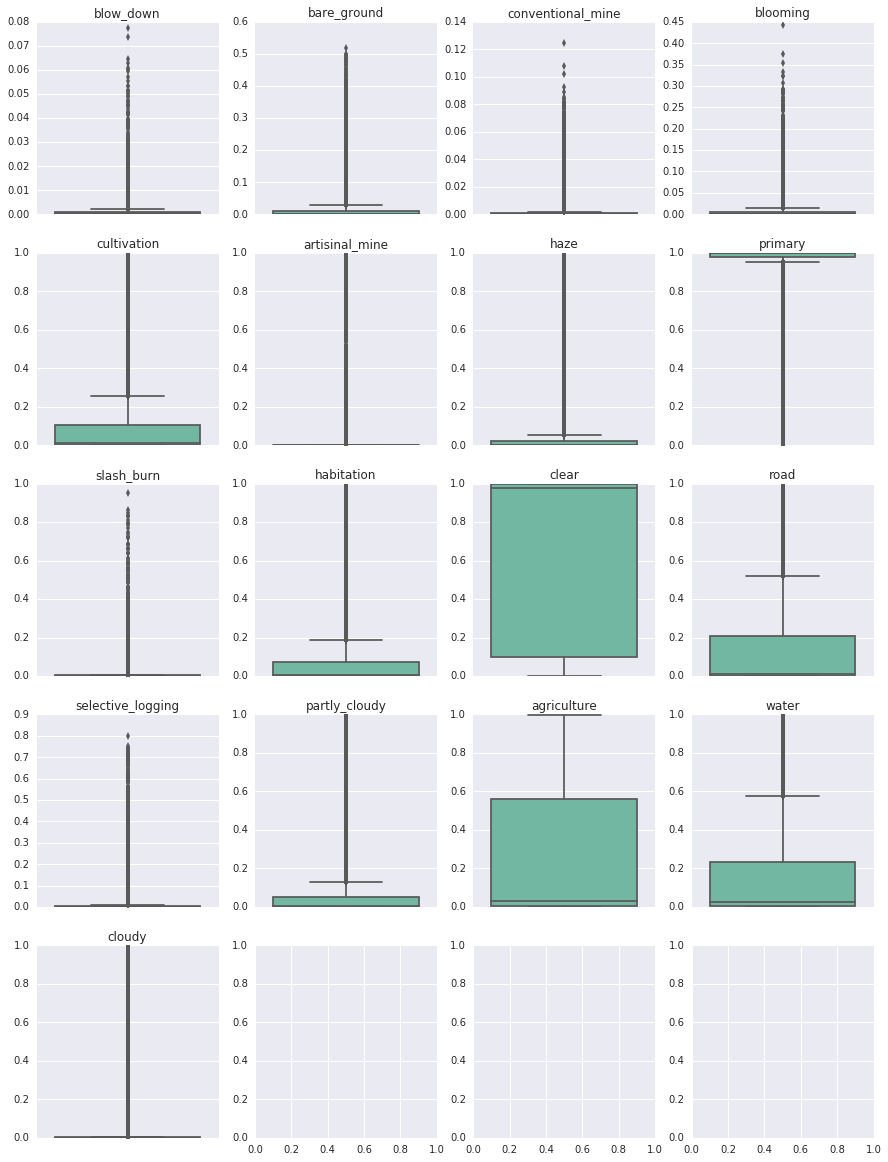

In [55]:
import seaborn as sns
tags_pred = np.array(preds).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels[i])


In [56]:
label_preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > thres, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    label_preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:58<00:00, 514.36it/s]


In [57]:
df_test["tags"] = label_preds
df_test.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy


In [60]:
submission_file = 'subm/vgg1_sample_plus_mahotas.csv'
df_test.to_csv(submission_file, index=False)
FileLink(submission_file)

/home/ubuntu/planet/subm/vgg1_sample_plus_mahotas.csv